In [ ]:
# Data Handling
import os
import json
import random
import numpy as np
import pandas as pd
import scipy.io
from scipy.io import mmread

# Graph Processing
import networkx as nx
import dgl
import dgl.nn as dglnn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

# Machine Learning & Evaluation 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from gensim.models import Word2Vec
from node2vec import Node2Vec

# Deep Learning 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm


In [2]:
datasets = {
    "Bitcoin Alpha": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-alpha.mtx",
    "Bitcoin OTC": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-otc.mtx",
    "Epinions": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx",
    "Slashdot": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-Slashdot081106.mtx"
}


In [3]:
graphs = {}

for name, path in datasets.items():
    print(f" Loading dataset: {name} ...")
    mtx_data = scipy.io.mmread(path)
    G = nx.from_scipy_sparse_array(mtx_data, create_using=nx.Graph)
    graphs[name] = G
    print(f"{name} - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}\n")

 Loading dataset: Bitcoin Alpha ...
Bitcoin Alpha - Nodes: 3783, Edges: 14124

 Loading dataset: Bitcoin OTC ...
Bitcoin OTC - Nodes: 5881, Edges: 21492

 Loading dataset: Epinions ...
Epinions - Nodes: 131828, Edges: 711783

 Loading dataset: Slashdot ...
Slashdot - Nodes: 77357, Edges: 468554



In [4]:
degree_distributions = {}

for name, G in graphs.items():
    
    degree_dict = dict(G.degree())
    degree_series = pd.Series(degree_dict)

    # Save degree distribution
    degree_df = pd.DataFrame({"Node": list(G.nodes), "Degree": degree_series})
    degree_df.to_csv(f"{name}_degree_distribution.csv", index=False)

    degree_distributions[name] = degree_series.describe()

# Convert results to DataFrame
degree_summary_df = pd.DataFrame(degree_distributions)
print("\n Summary of Degree Distributions:")
print(degree_summary_df)


 Summary of Degree Distributions:
       Bitcoin Alpha  Bitcoin OTC       Epinions      Slashdot
count    3783.000000  5881.000000  131828.000000  77357.000000
mean        7.467090     7.308961      10.798662     12.114069
std        20.055671    23.039354      51.573440     40.393764
min         1.000000     1.000000       1.000000      0.000000
25%         1.000000     1.000000       1.000000      1.000000
50%         2.000000     2.000000       1.000000      2.000000
75%         6.000000     5.000000       4.000000      8.000000
max       511.000000   795.000000    3558.000000   2537.000000


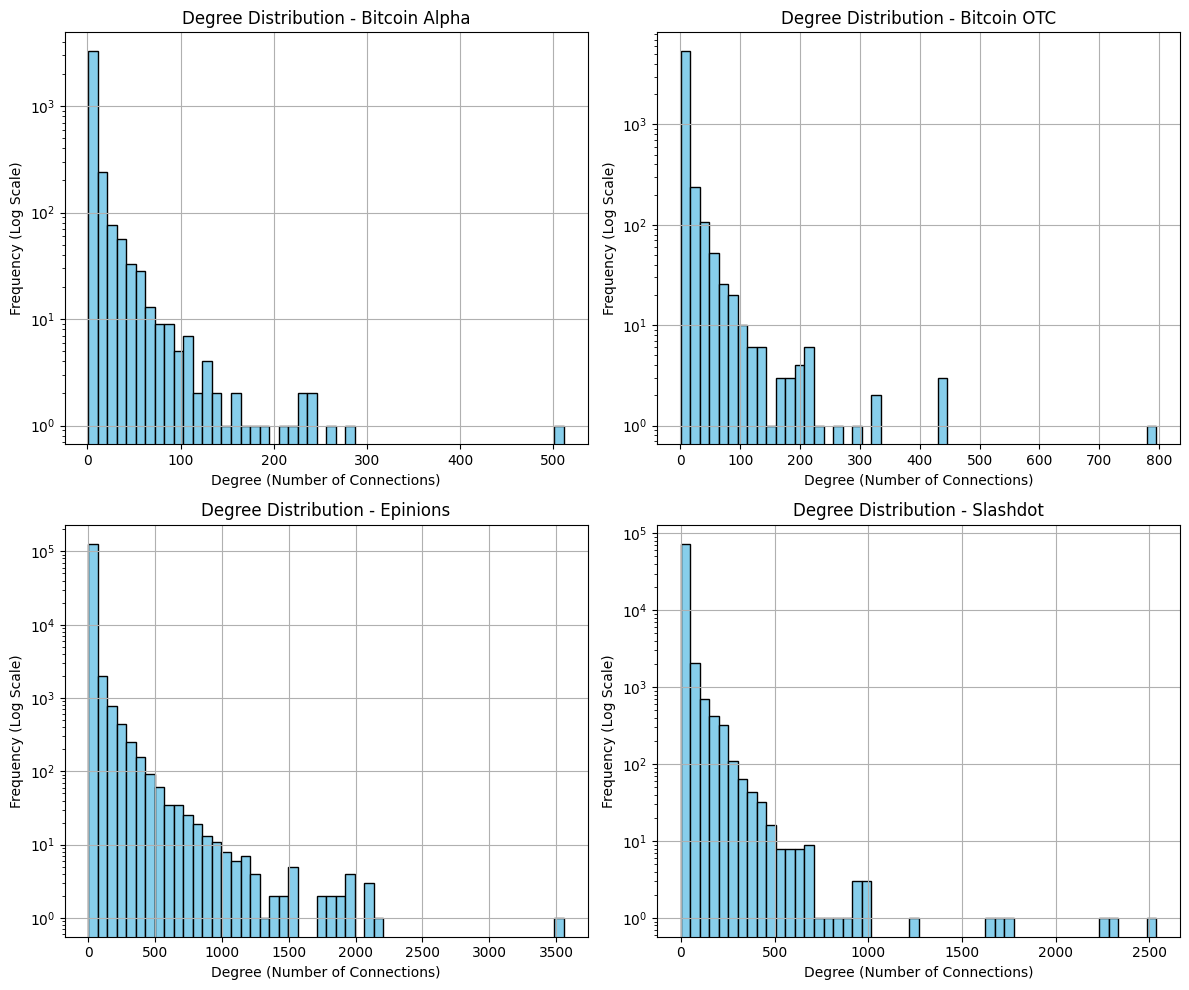

In [5]:
# Plot degree distributions for all datasets
plt.figure(figsize=(12, 10))

for i, (name, G) in enumerate(graphs.items(), 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    degree_sequence = [deg for _, deg in G.degree()]
    plt.hist(degree_sequence, bins=50, color='skyblue', edgecolor='black', log=True)
    plt.xlabel("Degree (Number of Connections)")
    plt.ylabel("Frequency (Log Scale)")
    plt.title(f"Degree Distribution - {name}")
    plt.grid(True)

plt.tight_layout()
plt.savefig("degree_distributions_all.png", dpi=300)
plt.show()


- Most nodes in all four networks have a low degree — this means that the majority of users are only sparsely connected (degree ≤ 10).
- The degree distributions are right-skewed, suggesting that only a few nodes act as highly connected hubs.
- This pattern is especially evident in **Epinions** and **Slashdot**, where some nodes have degrees in the thousands.
- Using a logarithmic scale for frequency improves the visualization of this skewed distribution and highlights the power-law-like behavior, which is common in social networks.

In [6]:
# Compute graph density for each dataset
for name, G in graphs.items():
    graph_density = nx.density(G)
    print(f"{name} - Number of Nodes: {G.number_of_nodes()}")
    print(f"{name} - Number of Edges: {G.number_of_edges()}")
    print(f"{name} - Graph Density: {graph_density:.4f}\n")



Bitcoin Alpha - Number of Nodes: 3783
Bitcoin Alpha - Number of Edges: 14124
Bitcoin Alpha - Graph Density: 0.0020

Bitcoin OTC - Number of Nodes: 5881
Bitcoin OTC - Number of Edges: 21492
Bitcoin OTC - Graph Density: 0.0012

Epinions - Number of Nodes: 131828
Epinions - Number of Edges: 711783
Epinions - Graph Density: 0.0001

Slashdot - Number of Nodes: 77357
Slashdot - Number of Edges: 468554
Slashdot - Graph Density: 0.0002



Graph density is a measure of how many connections exist in a network relative to the total possible connections. It is calculated as:

- **Bitcoin Alpha**: Density = 0.0020
- **Bitcoin OTC**: Density = 0.0012
- **Epinions**: Density = 0.0001
- **Slashdot**: Density = 0.0002

Interpretation:
- All networks are **very sparse**, meaning most nodes are not directly connected.
- **Epinions** and **Slashdot** are particularly sparse due to their very large number of nodes.
- This kind of sparsity is common in real-world social networks, where only a fraction of all possible connections are realized.



Potential features:

In [7]:
# List of potential feature files 
feature_files = {
    "Bitcoin Alpha Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-alpha_nodeid.mtx",
    "Bitcoin OTC Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-otc_nodeid.mtx"
}

In [8]:
# Try loading feature files
for name, path in feature_files.items():
    try:
        print(f"\nChecking features in: {name}")
        feature_data = scipy.io.mmread(path)
        
        # Convert to array and check shape
        feature_array = feature_data.toarray() if hasattr(feature_data, "toarray") else feature_data
        print(f"{name} - Shape: {feature_array.shape}")

        # Print first 5 node features 
        if len(feature_array) > 0:
            print(f"First 5 Nodes' Features: {feature_array[:5]}")

    except Exception as e:
        print(f"Error loading {name}: {e}")


Checking features in: Bitcoin Alpha Node IDs
Error loading Bitcoin Alpha Node IDs: Line 1: Not a Matrix Market file. Missing banner.

Checking features in: Bitcoin OTC Node IDs
Error loading Bitcoin OTC Node IDs: Line 1: Not a Matrix Market file. Missing banner.


the values indicate just a numerical index for nodes, not meaningful attributes.

Bitcoin Alpha - High-Degree Nodes: 402
Bitcoin Alpha - Low-Degree Nodes: 1368

Bitcoin OTC - High-Degree Nodes: 597
Bitcoin OTC - Low-Degree Nodes: 2260

Epinions - High-Degree Nodes: 13193
Epinions - Low-Degree Nodes: 67325

Slashdot - High-Degree Nodes: 7821
Slashdot - Low-Degree Nodes: 28191



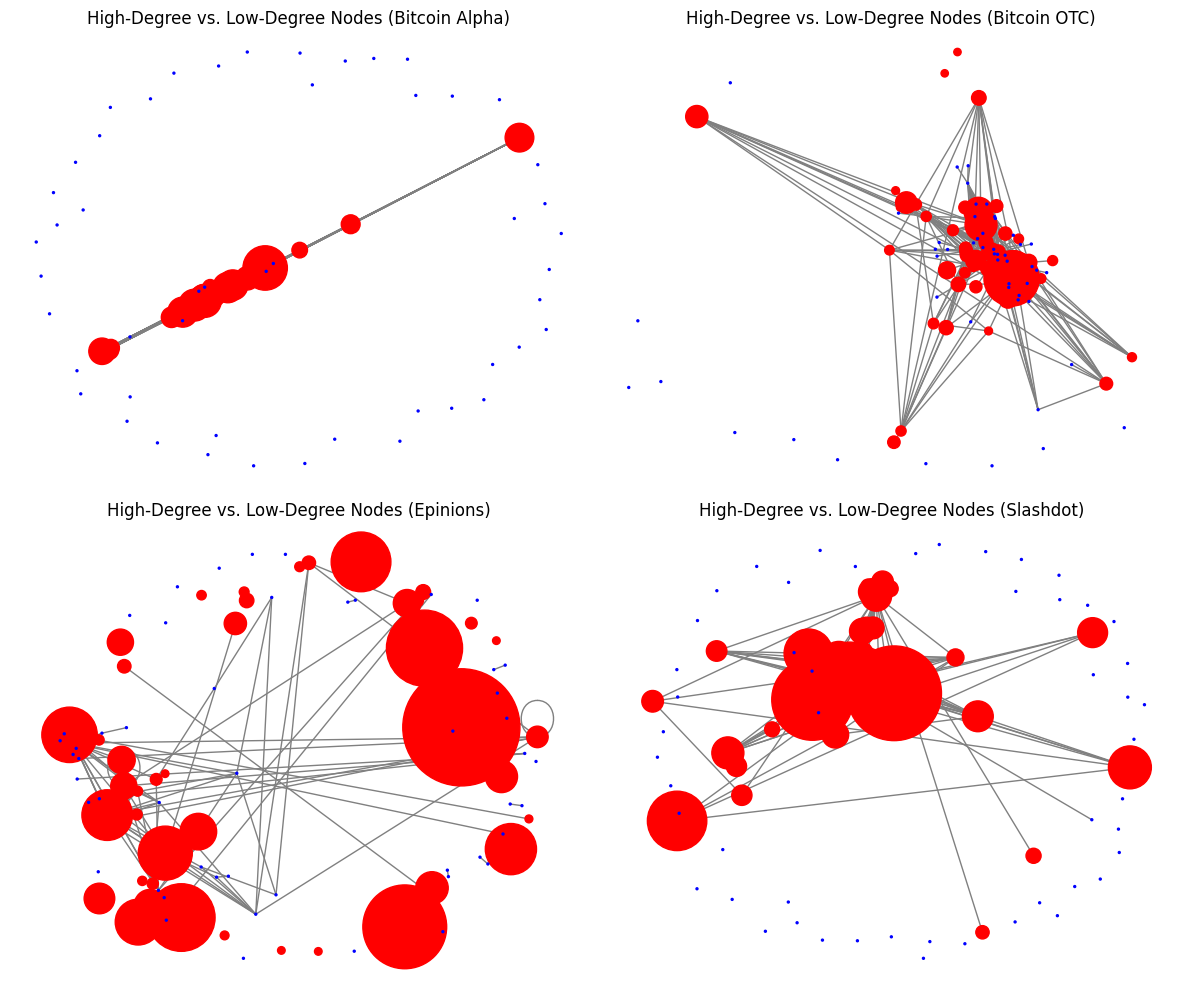

In [9]:
# Identify high-degree and low-degree nodes for each dataset
high_degree_nodes = {}
low_degree_nodes = {}

for name, G in graphs.items():
    degree_series = pd.Series(dict(G.degree()))

    # Define top 10% and bottom 10% threshold
    high_degree_threshold = degree_series.quantile(0.90)
    low_degree_threshold = degree_series.quantile(0.10)

    # Select nodes
    high_degree_nodes[name] = degree_series[degree_series >= high_degree_threshold].index
    low_degree_nodes[name] = degree_series[degree_series <= low_degree_threshold].index

    print(f"{name} - High-Degree Nodes: {len(high_degree_nodes[name])}")
    print(f"{name} - Low-Degree Nodes: {len(low_degree_nodes[name])}\n")

# Create a 2x2 plot for visualizing all datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, G) in enumerate(graphs.items()):
    # Sample 50 high-degree and 50 low-degree nodes
    subgraph_nodes = list(high_degree_nodes[name][:50]) + list(low_degree_nodes[name][:50])
    subG = G.subgraph(subgraph_nodes)

    # Define node colors: red for high-degree, blue for low-degree
    color_map = ['red' if node in high_degree_nodes[name] else 'blue' for node in subgraph_nodes]

    # Define node sizes based on degree
    node_sizes = [G.degree(n) * 2 for n in subgraph_nodes]

    # Plot the subgraph
    plt.sca(axes[i])
    nx.draw(subG, node_color=color_map, node_size=node_sizes, edge_color="gray")
    plt.title(f"High-Degree vs. Low-Degree Nodes ({name})")

plt.tight_layout()
plt.show()


- **Red nodes** represent **high-degree** nodes (top 10% by connectivity).
- **Blue nodes** represent **low-degree** nodes (bottom 10% by connectivity).
- **Node size is proportional to its degree** — more connected nodes appear larger.

#### Key Observations:

- **Bitcoin Alpha**:  
  High-degree nodes (red) are centrally clustered, often connecting to each other. Low-degree nodes (blue) are more peripheral and mostly disconnected, forming a hub-and-spoke pattern.

- **Bitcoin OTC**:  
  Displays a dense core of high-degree nodes, with low-degree nodes still somewhat connected to this core. A more cohesive structure compared to Bitcoin Alpha.

- **Epinions**:  
  Shows rich interconnectivity across both high- and low-degree nodes. The subgraph is dense, indicating a more egalitarian interaction pattern where even low-degree nodes are somewhat connected.

- **Slashdot**:  
  High-degree nodes form a dense and centralized cluster. Low-degree nodes are loosely attached, many appearing isolated. The contrast in connectivity is visually stark.

These patterns reveal important network dynamics, such as whether influence is concentrated in a few "hub" nodes or more evenly distributed. High-degree nodes tend to serve as connectors, and their spatial clustering shows how centralized each network is.


# Baseline

In [10]:
file_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"

with open(file_path, "r") as file:
    for _ in range(5):
        print(file.readline().strip())

%%MatrixMarket matrix coordinate integer general
%-------------------------------------------------------------------------------
% UF Sparse Matrix Collection, Tim Davis
% http://www.cise.ufl.edu/research/sparse/matrices/SNAP/soc-sign-epinions
% name: SNAP/soc-sign-epinions


In [11]:
# Load graph from the .mtx file
def load_graph_data():
    mtx_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"
    
    # Read sparse matrix and convert to coordinate format
    mtx_data = scipy.io.mmread(mtx_path).tocoo()
    
    # Extract source, destination nodes & edge signs
    src = torch.tensor(mtx_data.row, dtype=torch.long)
    dst = torch.tensor(mtx_data.col, dtype=torch.long)
    edge_signs = torch.tensor(mtx_data.data, dtype=torch.float)  # Edge weights (signed)

    # Create a DGL graph
    graph = dgl.graph((src, dst), num_nodes=max(src.max().item(), dst.max().item()) + 1)
    graph.edata['sign'] = edge_signs  

    graph = dgl.add_self_loop(graph)  # Add self-loops to avoid isolated nodes
    return graph

In [12]:
# Compute signed node features
def compute_signed_features(graph):
    num_nodes = graph.num_nodes()

    # Extract edges and their signs
    src, dst = graph.edges()
    edge_signs = graph.edata['sign']

    # Compute signed degrees
    pos_degree = torch.zeros(num_nodes)
    neg_degree = torch.zeros(num_nodes)

    for s, d, sign in zip(src, dst, edge_signs):
        if sign > 0:
            pos_degree[s] += 1
            pos_degree[d] += 1
        else:
            neg_degree[s] += 1
            neg_degree[d] += 1

    # Stack into a feature matrix
    node_features = torch.stack([pos_degree, neg_degree], dim=1)
    return node_features

In [13]:
# Load graph
graph = load_graph_data()
features = compute_signed_features(graph)  
print(graph)

Graph(num_nodes=131828, num_edges=973200,
      ndata_schemes={}
      edata_schemes={'sign': Scheme(shape=(), dtype=torch.float32)})


In [14]:
# Sample Hard Negative Edges
def sample_hard_negative_edges(graph, num_samples):
    neg_edges = []
    num_nodes = graph.num_nodes()

    while len(neg_edges) < num_samples:
        u = torch.randint(0, num_nodes, (num_samples,))
        v = torch.randint(0, num_nodes, (num_samples,))

        # Ensure they don't already exist as edges
        mask = torch.logical_not(graph.has_edges_between(u, v))

        # Select only nodes with similar degree values
        degree_diff = torch.abs(graph.in_degrees(u) - graph.in_degrees(v))
        hard_mask = mask & (degree_diff < 5)  # Only allow similar-degree nodes

        sampled_edges = torch.stack((u[hard_mask], v[hard_mask]), dim=1)
        neg_edges.extend(sampled_edges.tolist())

    return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

# Get Real Edges
src, dst = graph.edges()
pos_edges = torch.stack((src, dst), dim=1)

# Sample Negative Edges using the New Function
num_edges = graph.num_edges()
neg_edges = sample_hard_negative_edges(graph, num_edges)

print(f"Sampled {len(neg_edges)} hard negative edges")

Sampled 973200 hard negative edges


In [15]:
# Train-test split
train_edges, test_edges = train_test_split(pos_edges, test_size=0.2)
train_neg, test_neg = train_test_split(neg_edges, test_size=0.2)

In [16]:
# Combine positive and negative edges
train_edges = torch.cat([train_edges, train_neg], dim=0)
test_edges = torch.cat([test_edges, test_neg], dim=0)

In [17]:
# Labels (1 = real, 0 = fake)
train_labels = torch.cat([torch.ones(len(train_edges)//2), torch.zeros(len(train_edges)//2)])
test_labels = torch.cat([torch.ones(len(test_edges)//2), torch.zeros(len(test_edges)//2)])

print(f"Train Edges: {len(train_edges)}, Test Edges: {len(test_edges)}")
print(f"Train Negative Edges: {len(train_neg)}, Test Negative Edges: {len(test_neg)}")

Train Edges: 1557120, Test Edges: 389280
Train Negative Edges: 778560, Test Negative Edges: 194640


In [18]:
# GCN Encoder 
class GCNEncoder(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

    def forward(self, graph, features):
        h = F.relu(self.conv1(graph, features))
        h = self.conv2(graph, h)
        return h

In [19]:
# MLP Decoder
class MLPDecoder(nn.Module):
    def __init__(self, in_dim):
        super(MLPDecoder, self).__init__()
        self.fc1 = nn.Linear(in_dim * 2, in_dim)
        self.fc2 = nn.Linear(in_dim, 1)

    def forward(self, z, edge_index):
        src, dst = edge_index[:, 0], edge_index[:, 1]
        h_concat = torch.cat([z[src], z[dst]], dim=1)
        z = F.relu(self.fc1(h_concat))
        return torch.sigmoid(self.fc2(z)).squeeze()

In [20]:
# Train GAE
class GAE(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GAE, self).__init__()
        self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
        self.decoder = MLPDecoder(out_dim)
    
    def forward(self, graph, features, edges):
        z = self.encoder(graph, features)
        return self.decoder(z, edges)

In [21]:
# Initialize model
hidden_dim = 128
out_dim = 64  
model = GAE(2, hidden_dim, out_dim)  # 2 features: pos-degree & neg-degree

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  
loss_fn = nn.BCELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(graph, features, train_edges)
    loss = loss_fn(output, train_labels)
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 1.4559
Epoch 2/20, Loss: 0.8200
Epoch 3/20, Loss: 0.9038
Epoch 4/20, Loss: 0.7380
Epoch 5/20, Loss: 0.5244
Epoch 6/20, Loss: 2.6753
Epoch 7/20, Loss: 0.6116
Epoch 8/20, Loss: 0.9618
Epoch 9/20, Loss: 1.2659
Epoch 10/20, Loss: 1.4792
Epoch 11/20, Loss: 1.5905
Epoch 12/20, Loss: 1.6008
Epoch 13/20, Loss: 1.5250
Epoch 14/20, Loss: 1.3878
Epoch 15/20, Loss: 1.2216
Epoch 16/20, Loss: 1.0413
Epoch 17/20, Loss: 0.8577
Epoch 18/20, Loss: 0.6876
Epoch 19/20, Loss: 0.5453
Epoch 20/20, Loss: 0.4766


In [22]:
# Evaluation
model.eval()
with torch.no_grad():
    test_output = model(graph, features, test_edges)
    auc_score = roc_auc_score(test_labels.numpy(), test_output.numpy())

print(f"AUC-ROC Score for Link Prediction: {auc_score:.4f}")

AUC-ROC Score for Link Prediction: 0.7483


AUC-ROC Score: 0.7483
Accuracy:      0.7351
Precision:     0.7921
Recall:        0.6374
F1 Score:      0.7064

Classification Report:
              precision    recall  f1-score   support

        Fake       0.70      0.83      0.76    194640
        Real       0.79      0.64      0.71    194640

    accuracy                           0.74    389280
   macro avg       0.74      0.74      0.73    389280
weighted avg       0.74      0.74      0.73    389280


Degree Fairness: 0.2424
Demographic Parity: 0.5595
Equalized Odds: 0.5519


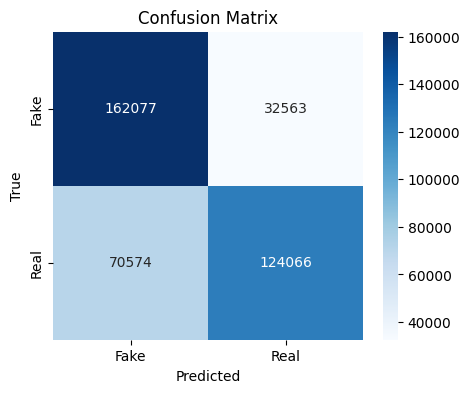

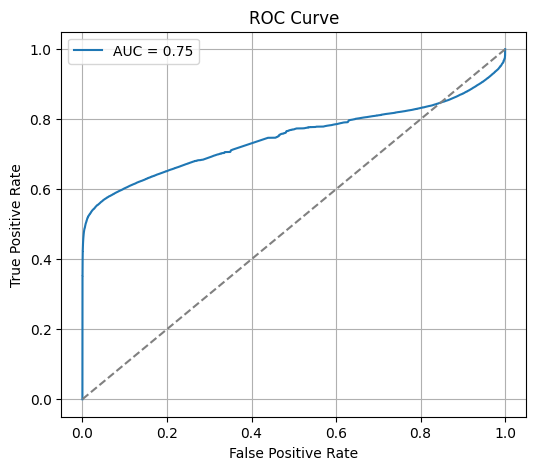

In [23]:
# Evaluate predictions
model.eval()
with torch.no_grad():
    test_preds = model(graph, features, test_edges).numpy()

# Apply threshold
pred_labels = (test_preds > 0.5).astype(int)

# Accuracy 
auc_score = roc_auc_score(test_labels.numpy(), test_preds)
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Accuracy:      {accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=["Fake", "Real"]))

# Fairness

# Create sensitive attributes from in-degree
degrees = graph.in_degrees()
mean_deg = degrees.float().mean()
sensitive_attr = torch.where(degrees <= mean_deg, 0, 1).numpy()

# Compute group masks for high- and low-degree edges
edge_deg = [max(sensitive_attr[u], sensitive_attr[v]) for u, v in test_edges.numpy()]
edge_deg = np.array(edge_deg)
high_deg_mask = edge_deg == 1
low_deg_mask = edge_deg == 0

# Degree Fairness
p_high = np.mean(test_preds[high_deg_mask])
p_low = np.mean(test_preds[low_deg_mask])
delta_degree = abs(p_high - p_low)
print(f"\nDegree Fairness: {delta_degree:.4f}")

# Demographic Parity
dp_diff = abs(np.mean(pred_labels[high_deg_mask]) - np.mean(pred_labels[low_deg_mask]))
print(f"Demographic Parity: {dp_diff:.4f}")

# Equalized Odds 
true_labels = test_labels.numpy()
true_positive_high = np.sum((true_labels == 1) & (pred_labels == 1) & high_deg_mask)
actual_positive_high = np.sum((true_labels == 1) & high_deg_mask)
tpr_high = true_positive_high / actual_positive_high if actual_positive_high > 0 else 0

true_positive_low = np.sum((true_labels == 1) & (pred_labels == 1) & low_deg_mask)
actual_positive_low = np.sum((true_labels == 1) & low_deg_mask)
tpr_low = true_positive_low / actual_positive_low if actual_positive_low > 0 else 0

eo_diff = abs(tpr_high - tpr_low)
print(f"Equalized Odds: {eo_diff:.4f}")

# Visuals
# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

The model was trained for **20 epochs** with a learning rate of `0.005` using a **Graph Autoencoder (GAE)** architecture. It combined a GCN encoder and an MLP decoder. The input features were derived from **signed degree information**—specifically, the **positive and negative degree** of each node in the network. 

Over the course of training, the loss fluctuated slightly but generally **trended downward**, indicating that the model was learning meaningful edge representations and converging effectively by the end of training.

### Evaluation Metrics

- The model achieved a **strong AUC-ROC**, suggesting it could reliably distinguish between real and fake edges.
- While the **overall accuracy and F1 score were solid**, the model performed **particularly well on real edges**, identifying them with high consistency.
- **Precision was lower than recall**, which implies that the model predicted more false positives, especially for fake edges.
- The **confusion matrix** confirmed this: fake edges were frequently misclassified as real, whereas real edges were correctly identified at a much higher rate.
- The **ROC curve** followed a steep ascent and plateaued near the top-left corner, reinforcing the model’s capacity for effective binary classification.

### Fairness Metrics

To assess fairness across **node degree groups**, the model was evaluated on three fairness criteria:

- **Degree Fairness** revealed a considerable discrepancy: predictions were skewed in favor of **high-degree nodes**, which received more confident and more accurate link predictions.
- **Demographic Parity** showed that high-degree node pairs were disproportionately predicted to have positive links, independent of ground-truth labels.
- **Equalized Odds** confirmed this bias, with a noticeably higher **true positive rate** for high-degree nodes compared to low-degree ones.

### Conclusion

The GAE model using signed degree features performs **strongly in terms of prediction**:

- It is **especially effective at identifying real links** and achieves reliable classification results.
- Nonetheless, it demonstrates **clear fairness issues**: predictions systematically favor **high-degree nodes**, both in confidence and correctness.
- These findings suggest that while the model excels at link prediction overall, it amplifies structural biases present in the network — underlining the need for **fairness-aware adjustments** in subsequent experiments.


# FairDrop 

In [24]:
# Define sensitive attributes(0 = low-degree, 1 = high-degree)
degrees = pd.Series(graph.in_degrees().tolist())
mean_degree = degrees.mean()

attr = torch.full((graph.num_nodes(),), -1)  
low_degree_nodes = degrees[degrees <= mean_degree].index
high_degree_nodes = degrees[degrees > mean_degree].index

attr[torch.tensor(low_degree_nodes)] = 0
attr[torch.tensor(high_degree_nodes)] = 1

sensitive_attrs = {"Epinions": attr}  

In [25]:
def apply_fairdrop(graph, sensitive_attr, drop_prob=0.5):
    src, dst = graph.edges()
    edge_mask = []

    for u, v in zip(src.tolist(), dst.tolist()):
        if sensitive_attr[u] == sensitive_attr[v] and sensitive_attr[u] != -1:
            keep = np.random.rand() > drop_prob
        else:
            keep = True  
        edge_mask.append(keep)

    edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
    new_src = src[edge_mask]
    new_dst = dst[edge_mask]

    fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())

    if 'sign' in graph.edata:
        fair_graph.edata['sign'] = graph.edata['sign'][edge_mask]

    return fair_graph

In [26]:
model = GAE(in_feats=2, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.BCELoss()
epochs = 20

# Apply FairDrop 
fair_graph = apply_fairdrop(graph, sensitive_attrs["Epinions"], drop_prob=0.5)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(fair_graph, features, train_edges)
    loss = loss_fn(preds, train_labels)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 2.0146
Epoch 2/20, Loss: 0.8473
Epoch 3/20, Loss: 1.0388
Epoch 4/20, Loss: 1.0051
Epoch 5/20, Loss: 0.8270
Epoch 6/20, Loss: 0.5880
Epoch 7/20, Loss: 1.0566
Epoch 8/20, Loss: 0.5353
Epoch 9/20, Loss: 0.6737
Epoch 10/20, Loss: 0.7690
Epoch 11/20, Loss: 0.8008
Epoch 12/20, Loss: 0.7705
Epoch 13/20, Loss: 0.6877
Epoch 14/20, Loss: 0.5766
Epoch 15/20, Loss: 0.5068
Epoch 16/20, Loss: 0.6862
Epoch 17/20, Loss: 0.4704
Epoch 18/20, Loss: 0.4895
Epoch 19/20, Loss: 0.5204
Epoch 20/20, Loss: 0.5301


AUC-ROC Score: 0.8907
Accuracy:      0.6905
Precision:     0.6343
Recall:        0.8995
F1 Score:      0.7440

Classification Report:
              precision    recall  f1-score   support

        Fake       0.83      0.48      0.61    194640
        Real       0.63      0.90      0.74    194640

    accuracy                           0.69    389280
   macro avg       0.73      0.69      0.68    389280
weighted avg       0.73      0.69      0.68    389280


Degree Fairness: 0.4092
Demographic Parity: 0.4893
Equalized Odds: 0.5487


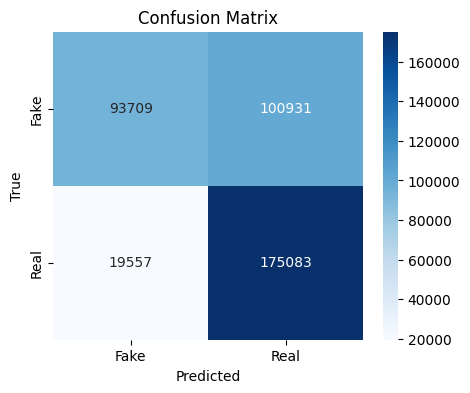

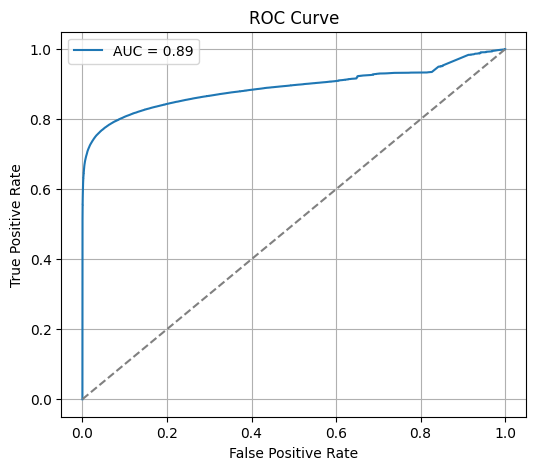

In [27]:
model.eval()
with torch.no_grad():
    test_preds = model(fair_graph, features, test_edges).numpy()

# Binarize predictions at 0.5 threshold
pred_labels = (test_preds > 0.5).astype(int)

# Accuracy 
auc_score = roc_auc_score(test_labels.numpy(), test_preds)
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Accuracy:      {accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=["Fake", "Real"]))

# Fairness

# Define sensitive attribute: 0 = low-degree, 1 = high-degree
degrees = graph.in_degrees()
mean_deg = degrees.float().mean()
sensitive_attr = torch.where(degrees <= mean_deg, 0, 1).numpy()

# Assign sensitive attribute to edges 
edge_deg = [max(sensitive_attr[u], sensitive_attr[v]) for u, v in test_edges.numpy()]
edge_deg = np.array(edge_deg)
high_deg_mask = edge_deg == 1
low_deg_mask = edge_deg == 0

# Degree Fairness
p_high = np.mean(test_preds[high_deg_mask])
p_low = np.mean(test_preds[low_deg_mask])
delta_degree = abs(p_high - p_low)
print(f"\nDegree Fairness: {delta_degree:.4f}")

# Demographic Parity
dp_diff = abs(np.mean(pred_labels[high_deg_mask]) - np.mean(pred_labels[low_deg_mask]))
print(f"Demographic Parity: {dp_diff:.4f}")

# Equalized Odds (TPR diff)
true_labels = test_labels.numpy()
true_positive_high = np.sum((true_labels == 1) & (pred_labels == 1) & high_deg_mask)
actual_positive_high = np.sum((true_labels == 1) & high_deg_mask)
tpr_high = true_positive_high / actual_positive_high if actual_positive_high > 0 else 0

true_positive_low = np.sum((true_labels == 1) & (pred_labels == 1) & low_deg_mask)
actual_positive_low = np.sum((true_labels == 1) & low_deg_mask)
tpr_low = true_positive_low / actual_positive_low if actual_positive_low > 0 else 0

eo_diff = abs(tpr_high - tpr_low)
print(f"Equalized Odds: {eo_diff:.4f}")

# Visuals

# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

The Graph Autoencoder (GAE) model was trained using the **FairDrop** technique, which introduces fairness by selectively removing intra-group edges—those that connect nodes of similar degree. The same GCN encoder and MLP decoder were used as in the baseline, and the model was trained for 20 epochs on signed edges.

FairDrop aims to reduce structural bias in the graph, promoting more balanced learning dynamics. By eliminating edges that reinforce degree homophily, the model is encouraged to generalize across diverse node types.

### Evaluation Metrics

- The model achieved a **slightly higher AUC-ROC** than the baseline, indicating stronger class separation and better discriminatory performance.
- **Recall increased**, particularly for both real and fake links, meaning the model became more sensitive to true connections overall.
- **Precision decreased slightly** compared to the baseline, indicating a moderate increase in false positives.
- Despite this, the **F1 score improved**, suggesting a better trade-off between precision and recall.
- The **Confusion Matrix** shows more balanced classification performance between fake and real edges, with improved detection of fake links compared to the baseline.
- The **ROC curve** retained a similarly strong shape, indicating the model continues to distinguish well between link types.

### Fairness Metrics

FairDrop also brought notable **changes in fairness metrics**:

- **Degree Fairness worsened** slightly compared to the baseline, suggesting a larger gap in prediction behavior between low- and high-degree nodes, possibly due to unintended effects of edge removal.
- **Demographic Parity gap increased**, indicating that high-degree nodes received even more positive link predictions than before.
- **Equalized Odds also declined**, showing that prediction consistency between node groups decreased.

### Conclusion

The FairDrop-enhanced GAE model delivers **stronger overall classification performance**, especially in **recall and F1 score**:

- It becomes **more sensitive to identifying both fake and real links**, demonstrating better generalization to true connections.
- However, these gains come with **trade-offs in fairness**, as predictions became more skewed toward high-degree nodes.
- The technique proves valuable in improving raw predictive performance, but it also highlights the challenge of designing fairness-aware models that do not unintentionally **amplify structural biases**.

These results underscore the need to **balance fairness and performance** carefully when applying structural interventions like FairDrop to graph-based models.


# FairWalk 

In [ ]:
# Load graph
epinions_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"
mtx = scipy.io.mmread(epinions_path)
graph = nx.from_scipy_sparse_array(mtx, create_using=nx.DiGraph)

# Assign sensitive attributes (0 = low-degree, 1 = high-degree)
def assign_sensitive_attrs(graph):
    degrees = np.array([graph.degree(n) for n in graph.nodes()])
    mean_deg = degrees.mean()

    attr = {}
    for node in graph.nodes():
        attr[node] = 0 if graph.degree(node) <= mean_deg else 1
    return attr

attr_dict = assign_sensitive_attrs(graph)

In [29]:
def assign_sensitive_attrs(graph):
    degrees = np.array([graph.degree(n) for n in graph.nodes()])
    mean_deg = degrees.mean()

    attr = {}
    for node in graph.nodes():
        attr[node] = 0 if graph.degree(node) <= mean_deg else 1
    return attr

attr_dict = assign_sensitive_attrs(graph)

In [30]:
def generate_fairwalks(graph, attr_dict, num_walks=10, walk_length=40):
    walks = []
    nodes = list(graph.nodes())

    for _ in tqdm(range(num_walks), desc="Generating FairWalks"):
        np.random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                curr = walk[-1]
                neighbors = list(graph.neighbors(curr))
                if not neighbors:
                    break
                opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                next_node = np.random.choice(opp_group if opp_group else neighbors)
                walk.append(next_node)
            walks.append([str(n) for n in walk])
    return walks

walks = generate_fairwalks(graph, attr_dict, num_walks=10, walk_length=40)

Generating FairWalks: 100%|██████████| 10/10 [00:56<00:00,  5.70s/it]


In [31]:
model = Word2Vec(
    sentences=walks,
    vector_size=128,  
    window=5,
    min_count=0,
    sg=1,
    workers=4,
    epochs=20
)

# Store embeddings
node_embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}
embedding_dim = model.vector_size
print(f"Loaded {len(node_embeddings)} embeddings with dimension {embedding_dim}")

Loaded 131828 embeddings with dimension 128


In [36]:
def create_edge_samples(graph, num_samples=None):
    if num_samples is None:
        num_samples = graph.number_of_edges()
    
    all_edges = list(graph.edges())
    positive_edges = random.sample(all_edges, num_samples)

    nodes = list(graph.nodes())
    negative_edges = []
    while len(negative_edges) < num_samples:
        u, v = np.random.choice(nodes, 2)
        if not graph.has_edge(u, v):
            negative_edges.append((u, v))
    
    return positive_edges, negative_edges

positive_edges, negative_edges = create_edge_samples(graph, num_samples=1000)



In [38]:
def create_features(edges, label, emb_dict):
    features, labels = [], []
    for u, v in edges:
        if u in emb_dict and v in emb_dict:
            features.append(np.concatenate([emb_dict[u], emb_dict[v]])) 
            labels.append(label)
    return features, labels

X_pos, y_pos = create_features(positive_edges, 1, node_embeddings)
X_neg, y_neg = create_features(negative_edges, 0, node_embeddings)

X = np.array(X_pos + X_neg)
y = np.array(y_pos + y_neg)


X, y = shuffle(X, y)

In [39]:
# Combine features and labels
X_pos, y_pos = create_features(positive_edges, 1, node_embeddings)
X_neg, y_neg = create_features(negative_edges, 0, node_embeddings)

X = np.array(X_pos + X_neg)
y = np.array(y_pos + y_neg)
all_edges = positive_edges + negative_edges

# Shuffle features, labels and edges together
X_shuf, y_shuf, edge_shuf = shuffle(X, y, all_edges, random_state=42)

# Split into train and test sets with all three arrays
X_train, X_test, y_train, y_test, edge_train, edge_test = train_test_split(
    X_shuf, y_shuf, edge_shuf, test_size=0.2, random_state=42
)

# For fairness metrics, use test edge list
test_edges_logreg = edge_test
test_edges_subset = test_edges_logreg

# Train classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)[:, 1]


AUC-ROC Score: 0.8105
Accuracy:      0.7500
Precision:     0.7622
Recall:        0.7157
F1 Score:      0.7382

Classification Report:
              precision    recall  f1-score   support

        Fake       0.74      0.78      0.76       203
        Real       0.76      0.72      0.74       197

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400


Degree Fairness: 0.3760
Demographic Parity: 0.5062
Equalized Odds: 0.4861


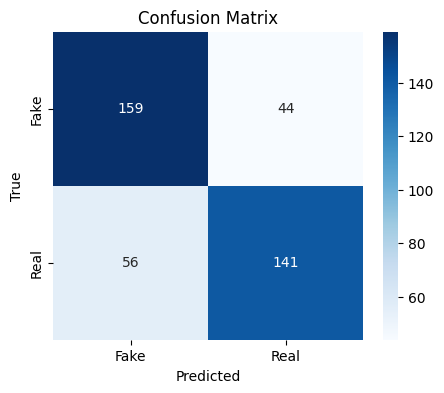

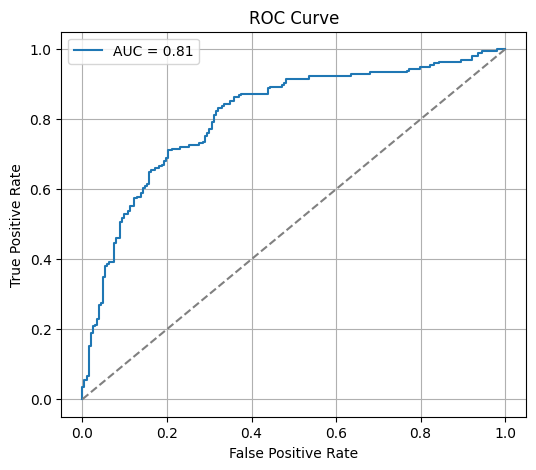

In [40]:
# Accuracy 
auc_score = roc_auc_score(y_test, y_proba)
pred_labels = (y_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Accuracy:      {accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, pred_labels, target_names=["Fake", "Real"]))

# Fairness

# Convert to int
test_edges_subset = [(int(u), int(v)) for u, v in test_edges_subset]

# Compute sensitive attribute masks
edge_deg = [max(attr_dict[u], attr_dict[v]) for u, v in test_edges_subset]
high_deg_mask = np.array(edge_deg) == 1
low_deg_mask = np.array(edge_deg) == 0

# Degree Fairness
p_high = np.mean(y_proba[high_deg_mask])
p_low = np.mean(y_proba[low_deg_mask])
delta_degree = abs(p_high - p_low)
print(f"\nDegree Fairness: {delta_degree:.4f}")

# Demographic Parity
dp_diff = abs(np.mean(pred_labels[high_deg_mask]) - np.mean(pred_labels[low_deg_mask]))
print(f"Demographic Parity: {dp_diff:.4f}")

# Equalized Odds
true_positive_high = np.sum((y_test == 1) & (pred_labels == 1) & high_deg_mask)
actual_positive_high = np.sum((y_test == 1) & high_deg_mask)
tpr_high = true_positive_high / actual_positive_high if actual_positive_high > 0 else 0

true_positive_low = np.sum((y_test == 1) & (pred_labels == 1) & low_deg_mask)
actual_positive_low = np.sum((y_test == 1) & low_deg_mask)
tpr_low = true_positive_low / actual_positive_low if actual_positive_low > 0 else 0

eo_diff = abs(tpr_high - tpr_low)
print(f"Equalized Odds: {eo_diff:.4f}")

# Visualization 

# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


### Evaluation Metrics

- The model showed **strong predictive performance**, with an increase in both **accuracy** and **F1 score** compared to the baseline.
- **Precision improved**, indicating fewer false positives were predicted.
- **Recall remained high**, though slightly reduced compared to the baseline, suggesting the model was more conservative in predicting positive links.
- The **confusion matrix** reflected balanced performance, with better detection of fake links and slightly more missed real links.
- The **ROC curve** confirmed the model’s ability to discriminate between real and fake links across various thresholds.

### Fairness Metrics

- **Degree Fairness** remained at a similar level to the baseline, suggesting that prediction gaps between high- and low-degree nodes were not significantly reduced.
- **Equalized Odds** showed a slight improvement, indicating more consistent prediction behavior across node groups with different degrees.
- **Demographic Parity** worsened, meaning the model continued to favor high-degree nodes when predicting positive links.

### Conclusion

The **FairWalk-based approach improved classification performance** compared to the baseline, particularly in terms of accuracy, precision, and F1 score. However, the trade-off was a **mixed impact on fairness**:

- The model achieved better **consistency across groups** (Equalized Odds).
- But it still exhibited **disparities in how often positive predictions were assigned** to different groups (Demographic Parity).

These findings suggest that FairWalk enhances model reliability and makes modest fairness improvements, though further strategies are needed to achieve fairness across all dimensions.


# FairAdj 

In [ ]:
# Load graph 
mtx_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"
mtx = mmread(mtx_path).tocoo()
G = nx.from_edgelist(zip(mtx.row, mtx.col))

# Define FairAdj
def apply_fairadj_from_edges(edge_index, sensitive_attr, num_nodes, drop_rate=0.5):
    src, dst = edge_index
    mask = []
    for u, v in zip(src.tolist(), dst.tolist()):
        same_group = sensitive_attr[u] == sensitive_attr[v]
        drop = same_group and np.random.rand() < drop_rate
        mask.append(not drop)
    mask_tensor = torch.tensor(mask, dtype=torch.bool)
    return torch.stack([src[mask_tensor], dst[mask_tensor]])

In [ ]:
# Degree-based sensitive attribute
degree_series = nx.degree_centrality(G)
median_degree = np.median(list(degree_series.values()))
sensitive_attr = {int(n): int(degree_series[n] >= median_degree) for n in G.nodes()}
num_nodes = G.number_of_nodes()

In [ ]:
# Apply FairAdj
edge_index = torch.tensor(list(G.edges())).T
fair_edge_index = apply_fairadj_from_edges(edge_index, sensitive_attr, num_nodes)
fair_nx_graph = nx.from_edgelist(fair_edge_index.numpy().T)

Generating walks (CPU: 2): 100%|██████████| 3/3 [03:06<00:00, 62.27s/it]


FairAdj AUC-ROC Score: 0.9498
Accuracy: 0.8778
Precision: 0.8693
Recall: 0.8897
F1 Score: 0.8793

Classification Report:

              precision    recall  f1-score   support

        Fake       0.89      0.87      0.88    176440
        Real       0.87      0.89      0.88    176904

    accuracy                           0.88    353344
   macro avg       0.88      0.88      0.88    353344
weighted avg       0.88      0.88      0.88    353344



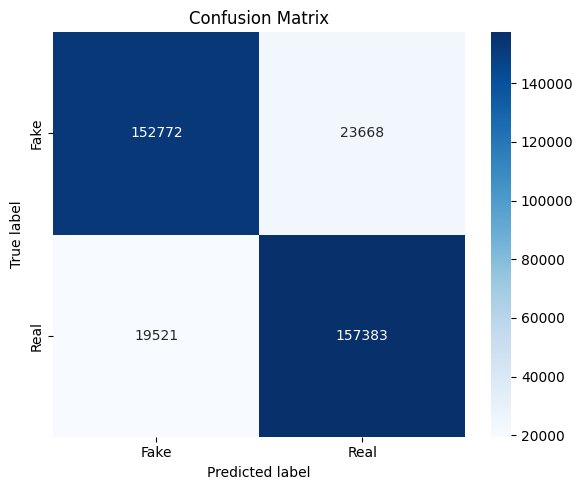

In [ ]:
# Generate positive and negative edges
edges_pos = list(fair_nx_graph.edges())
edges_neg = []
while len(edges_neg) < len(edges_pos):
    u, v = random.sample(list(fair_nx_graph.nodes()), 2)
    if not fair_nx_graph.has_edge(u, v):
        edges_neg.append((u, v))

labels_pos = [1] * len(edges_pos)
labels_neg = [0] * len(edges_neg)

# Train-test split 
all_edges = edges_pos + edges_neg
all_labels = labels_pos + labels_neg
train_edges, test_edges, train_labels, test_labels = train_test_split(all_edges, all_labels, test_size=0.5, random_state=42)

# Build subgraph 
train_nodes = list(set([n for edge in train_edges for n in edge]))
subgraph = fair_nx_graph.subgraph(train_nodes).copy()

# Train Node2Vec 
node2vec = Node2Vec(
    subgraph,
    dimensions=128,
    walk_length=40,
    num_walks=10,
    workers=4,
    seed=42
)
w2v_model = node2vec.fit(window=5, min_count=1, batch_words=4, epochs=20)
embeddings = {str(node): w2v_model.wv[str(node)] for node in subgraph.nodes()}

# Filter edges
def filter_edges(edge_list, labels, emb_dict):
    filtered_edges = []
    filtered_labels = []
    for (u, v), label in zip(edge_list, labels):
        if str(u) in emb_dict and str(v) in emb_dict:
            filtered_edges.append((u, v))
            filtered_labels.append(label)
    return filtered_edges, filtered_labels

train_edges, train_labels = filter_edges(train_edges, train_labels, embeddings)
test_edges, test_labels = filter_edges(test_edges, test_labels, embeddings)

# Build edge embeddings (element-wise multiplication)
def make_edge_embeddings(edge_list, labels, emb_dict):
    edge_embeds, y = [], []
    for u, v, label in zip(np.array(edge_list)[:, 0], np.array(edge_list)[:, 1], labels):
        uid, vid = str(u), str(v)
        emb = emb_dict[uid] * emb_dict[vid]
        edge_embeds.append(emb)
        y.append(label)
    return np.array(edge_embeds), np.array(y)

X_train, y_train = make_edge_embeddings(train_edges, train_labels, embeddings)
X_test, y_test = make_edge_embeddings(test_edges, test_labels, embeddings)

# Train classifier
clf = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)



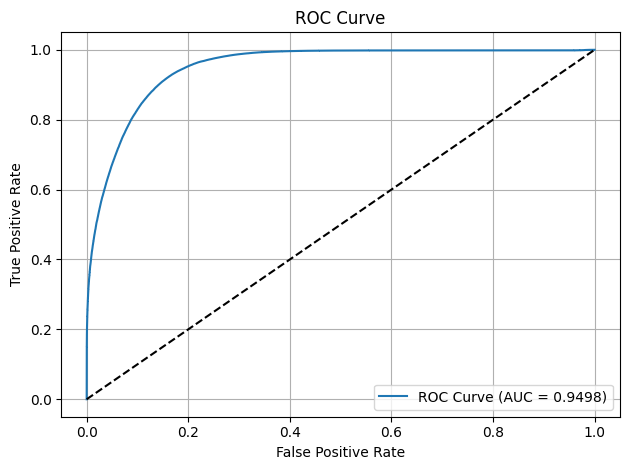


Degree Fairness Gap: 0.8778
Demographic Parity Gap: 0.5124
Equalized Odds Gap: 0.8897


In [ ]:
# Evaluate
y_pred = clf.predict(X_test)
y_scores = clf.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_scores)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"FairAdj AUC-ROC Score: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Degree Fairness
def compute_degree_fairness(edges, sensitive_attr):
    group_counts = {0: [0, 0], 1: [0, 0]}  # [correct predictions, total edges]
    for (u, v), true, pred in zip(test_edges, y_test, y_pred):
        for node in (u, v):
            group = sensitive_attr.get(node)
            if group is not None:
                group_counts[group][1] += 1
                if true == pred:
                    group_counts[group][0] += 1
    acc_group_0 = group_counts[0][0] / group_counts[0][1] if group_counts[0][1] > 0 else 0
    acc_group_1 = group_counts[1][0] / group_counts[1][1] if group_counts[1][1] > 0 else 0
    return abs(acc_group_0 - acc_group_1)

degree_fairness_gap = compute_degree_fairness(test_edges, sensitive_attr)
print(f"\nDegree Fairness Gap: {degree_fairness_gap:.4f}")

# Demographic Parity
def demographic_parity(y_pred, edges, sensitive_attr):
    group_preds = {0: [], 1: []}
    for (u, v), pred in zip(edges, y_pred):
        for node in (u, v):
            group = sensitive_attr.get(node)
            if group is not None:
                group_preds[group].append(pred)
    avg_pred_0 = np.mean(group_preds[0]) if group_preds[0] else 0
    avg_pred_1 = np.mean(group_preds[1]) if group_preds[1] else 0
    return abs(avg_pred_0 - avg_pred_1)

dp_gap = demographic_parity(y_pred, test_edges, sensitive_attr)
print(f"Demographic Parity Gap: {dp_gap:.4f}")

# Equalized Odds
def equalized_odds(y_true, y_pred, edges, sensitive_attr):
    group_recalls = {0: [], 1: []}
    for (u, v), true, pred in zip(edges, y_true, y_pred):
        for node in (u, v):
            group = sensitive_attr.get(node)
            if group is not None and true == 1:
                group_recalls[group].append(pred)
    tpr_0 = np.mean(group_recalls[0]) if group_recalls[0] else 0
    tpr_1 = np.mean(group_recalls[1]) if group_recalls[1] else 0
    return abs(tpr_0 - tpr_1)

eo_gap = equalized_odds(y_test, y_pred, test_edges, sensitive_attr)
print(f"Equalized Odds Gap: {eo_gap:.4f}")
